<h1 align="center">Ejemplos de linealización de datos</h1>
<div align="right">David A. Miranda, PhD<br>2022<br>Modificado el 16 de septiembre de 2023</div>

## 1. Importar librería

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import sys
is_colab = False
if 'google.colab' in sys.modules:
    from google.colab import files
    is_colab = True

## 2. Cargar los datos

Para este ejercicio se utilizarán datos de la Tasa Representativa del Mercado (TRM - peso por dolar) publicados por el Banco de la República de Colombia: [https://www.banrep.gov.co/es/estadisticas/trm](https://www.banrep.gov.co/es/estadisticas/trm).

Si usa Colab, suba el archivo .xlsx o .csv. 
Si trabaja local, de ser el caso, actualice la ruta y nombre del archivo en **file_name**.

In [2]:
file_name = '../data/1.1.2.TCM_Para rango de fechas dado.csv'
number_of_header_row = 8
if is_colab:
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
df = pd.DataFrame([])
if '.xlsx' in file_name:
    df = pd.read_excel(file_name, header=number_of_header_row)
if '.csv' in file_name:
    df = pd.read_csv(file_name)
df

,Año,Fecha (dd/mm/aaaa),TRM,Día del mes,Mes,Id Mes
0,2023,2023-09-16,"3928,28",16,Septiembre,9
1,2023,2023-09-15,"3926,59",15,Septiembre,9
2,2023,2023-09-14,"3950,92",14,Septiembre,9
3,2023,2023-09-13,"3993,53",13,Septiembre,9
4,2023,2023-09-12,"3997,74",12,Septiembre,9
...,...,...,...,...,...,...
619,2022,2022-01-05,"4084,11",5,Enero,1
620,2022,2022-01-04,"4082,75",4,Enero,1
621,2022,2022-01-03,"3981,16",3,Enero,1
622,2022,2022-01-02,"3981,16",2,Enero,1


## 3. Analítica de datos

### 3.1. Limpieza y pre-procesamiento de los datos

In [3]:
trm_label = ''
day_label = ''
date_label = ''
for c in df.columns:
    if 'TRM' in c.upper():
        trm_label = c
        df[trm_label] = df[trm_label].astype(str)
        df[trm_label] = df[trm_label].str.replace(',', '.', regex=True)
        df[trm_label] = pd.to_numeric(df[trm_label], errors='coerce')
    if 'día' in c.lower():
        day_label = c
    if 'fecha' in c.lower():
        date_label = c
df

,Año,Fecha (dd/mm/aaaa),TRM,Día del mes,Mes,Id Mes
0,2023,2023-09-16,3928.28,16,Septiembre,9
1,2023,2023-09-15,3926.59,15,Septiembre,9
2,2023,2023-09-14,3950.92,14,Septiembre,9
3,2023,2023-09-13,3993.53,13,Septiembre,9
4,2023,2023-09-12,3997.74,12,Septiembre,9
...,...,...,...,...,...,...
619,2022,2022-01-05,4084.11,5,Enero,1
620,2022,2022-01-04,4082.75,4,Enero,1
621,2022,2022-01-03,3981.16,3,Enero,1
622,2022,2022-01-02,3981.16,2,Enero,1


In [4]:
def get_date_time(this_date):
    this_date_ok = None
    if isinstance(this_date, str):
        try:
            this_date_ok = dt.datetime.strptime(this_date, '%Y-%m-%d')
        except ValueError:
            pass
    return this_date_ok

In [5]:
t = []
x = []
columns = df.columns
oldest_date = get_date_time(df[date_label].min())
for index, row in df.iterrows():
    if date_label == '':
        print('Error: no hay columna con Fecha')
        break
    this_date = get_date_time(row[date_label])
    this_TRM = np.NaN
    if this_TRM == '':
        print('Error: no hay columna con el nombre TRM')
        break
    this_TRM = row[trm_label]
    if not isinstance(this_date, dt.date):
        # Descarta los datos donde la columna de fechas no tiene formato de fecha
        continue
    t.append((this_date - oldest_date).days)
    x.append(this_TRM)
t = np.array(t)
x = np.array(x)

### 3.2. Obtención de pendientes e interceptos: linealización

In [6]:
def linealize(tau=15): # días
    delta_t = []
    delta_x = []
    slopes = []
    intercepts = []

    for idx, i in enumerate(range(tau, len(t), tau)):
        # Pendientes e interceptos de tramos pares
        this_t = t[i-tau:i]
        this_x = x[i-tau:i]
        p = np.r_[np.nan, np.nan]
        if idx%2 == 0:
            p = np.polyfit(this_t, this_x, 1)
        delta_t.append([this_t[0], this_t[-1]])
        delta_x.append([this_x[0], this_x[-1]])
        slopes.append(p[0])
        intercepts.append(p[1])

    for idx in range(1, len(slopes), 2):
        # Empalme de pendientes de tramos pares con líneas que unen los tramos: pendientes e interceptos impares
        if idx+1 >= len(slopes):
            break
        p1 = slopes[idx-1], intercepts[idx-1]
        p2 = slopes[idx+1], intercepts[idx+1]
        t1, t2 = delta_t[idx]
        x1 = p1[0] * t1 + p1[1]
        x2 = p2[0] * t2 + p2[1]
        slopes[idx] = (x2-x1) / (t2-t1)
        intercepts[idx] = x1 - slopes[idx] * t1
        delta_x[idx] = [x1, x2]
    return delta_t, delta_x, slopes, intercepts

### 3.3. Método para graficar datos y lineal por segmentos (linealización)

In [7]:
def plot_TMR_linealized(tau=15, TRM_min=3000, TRM_max=6000):
    delta_t, delta_x, slopes, intercepts = linealize(tau=tau)
    plt.plot(t, x,'.', label='TRM diario')
    for k in range(len(slopes)):
    # Gráfica de linealización con identificación de puntos de empalme
        p = np.r_[slopes[k], intercepts[k]]
        plt.plot(delta_t[k], np.polyval(p, delta_t[k]), 'k', lw=2)
        if k == 0:
            plt.plot(delta_t[k], np.polyval(p, delta_t[k]), 'k', lw=2, label='Linealización')
        if k%2 == 1:
            plt.plot(delta_t[k], delta_x[k], 'or')
            if k==1:
                plt.plot(delta_t[k], delta_x[k], 'or', label='Empalmes')
                plt.text(delta_t[k][0]-30, delta_x[k][0]+80, '$ %0.1f' % delta_x[k][0], c='r')
    dates = [oldest_date + dt.timedelta(days=int(day-1)) for day in t]
    filtered_days = [t[k] for k in range(len(dates)) if dates[k].day == 1]
    filtered_dates = [date for date in dates if date.day == 1]
    date_labels = [date.strftime('%Y-%m-1') for date in filtered_dates]
    plt.xticks(filtered_days, date_labels, rotation=45, fontsize=8)
    plt.legend()
    plt.xlabel('Fechas / Año-Mes-Día')
    plt.ylabel(trm_label)
    _ = plt.ylim(TRM_min, TRM_max)

### 3.4. Gráfica del modelo linealizado y predicciones

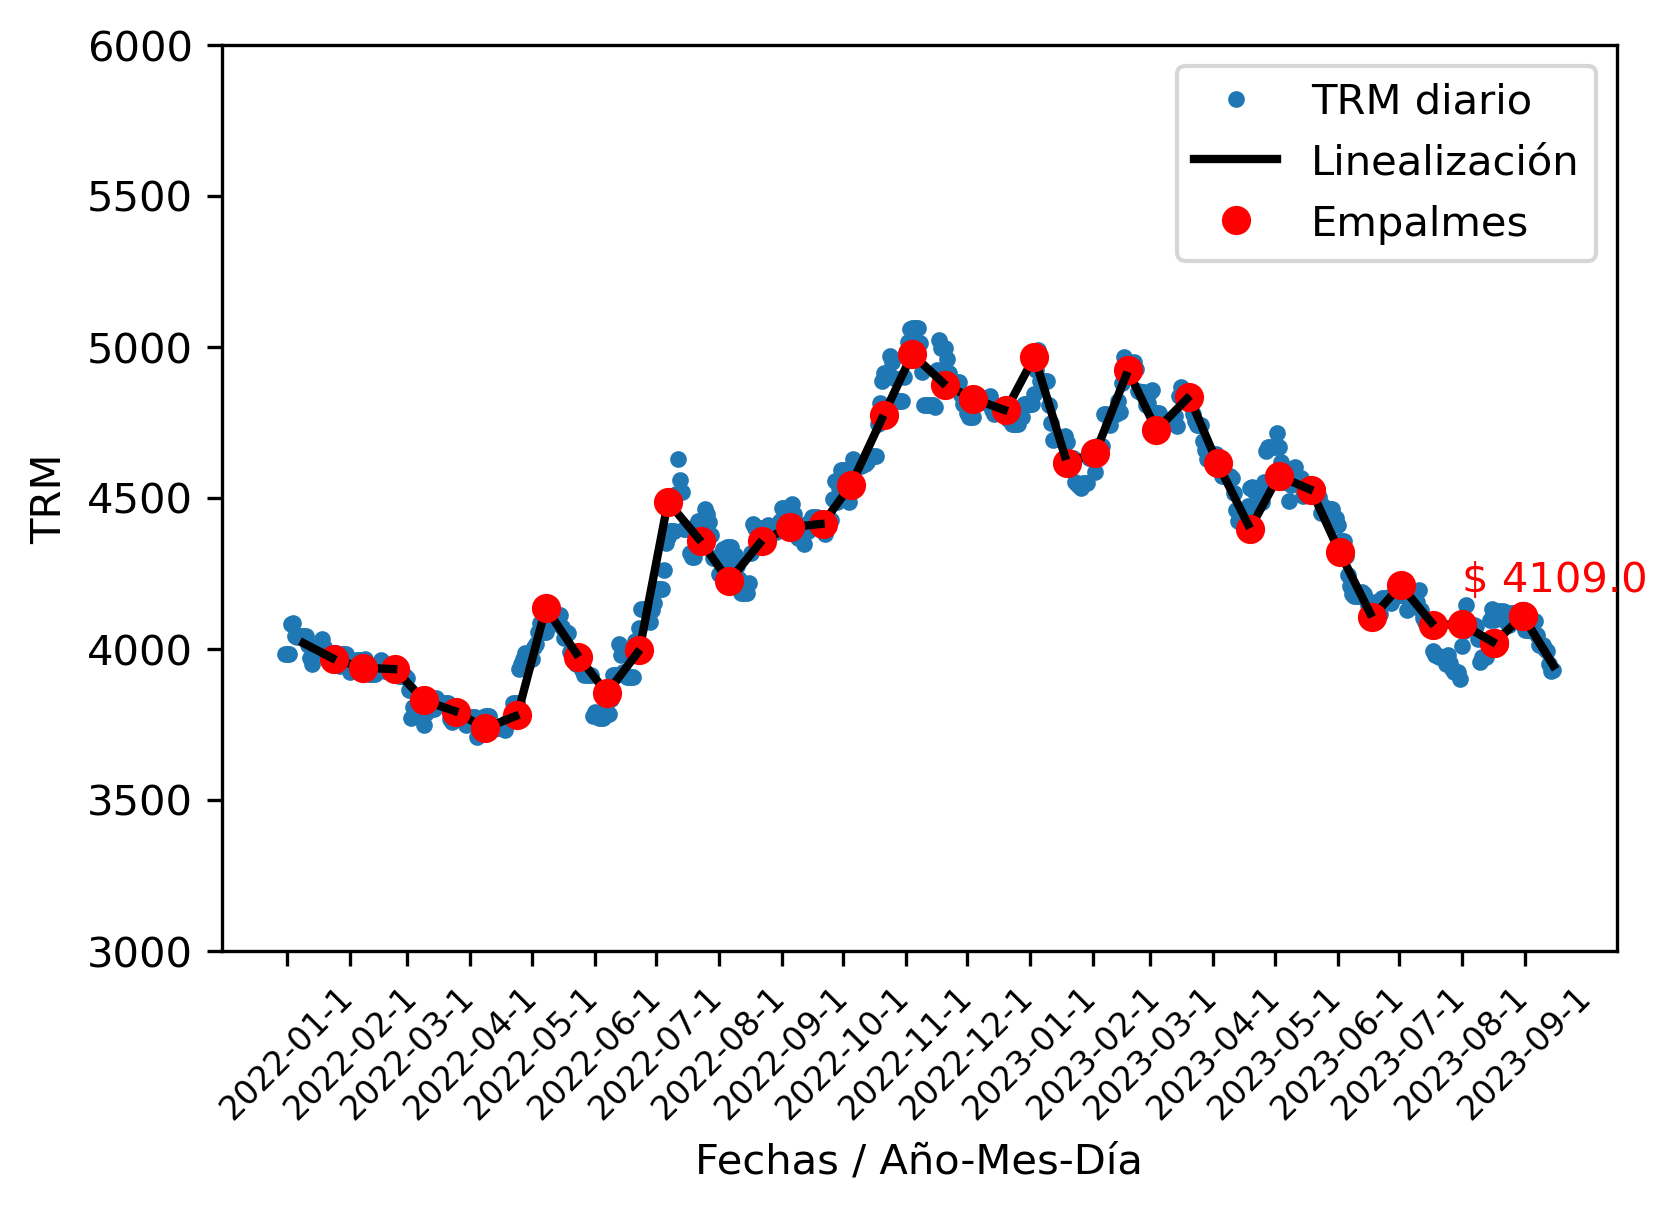

In [8]:
plt.figure(dpi=300)
plot_TMR_linealized(TRM_min=3000, TRM_max=6000)

Text(598, 3670.872601408972, '$ 3890.9')

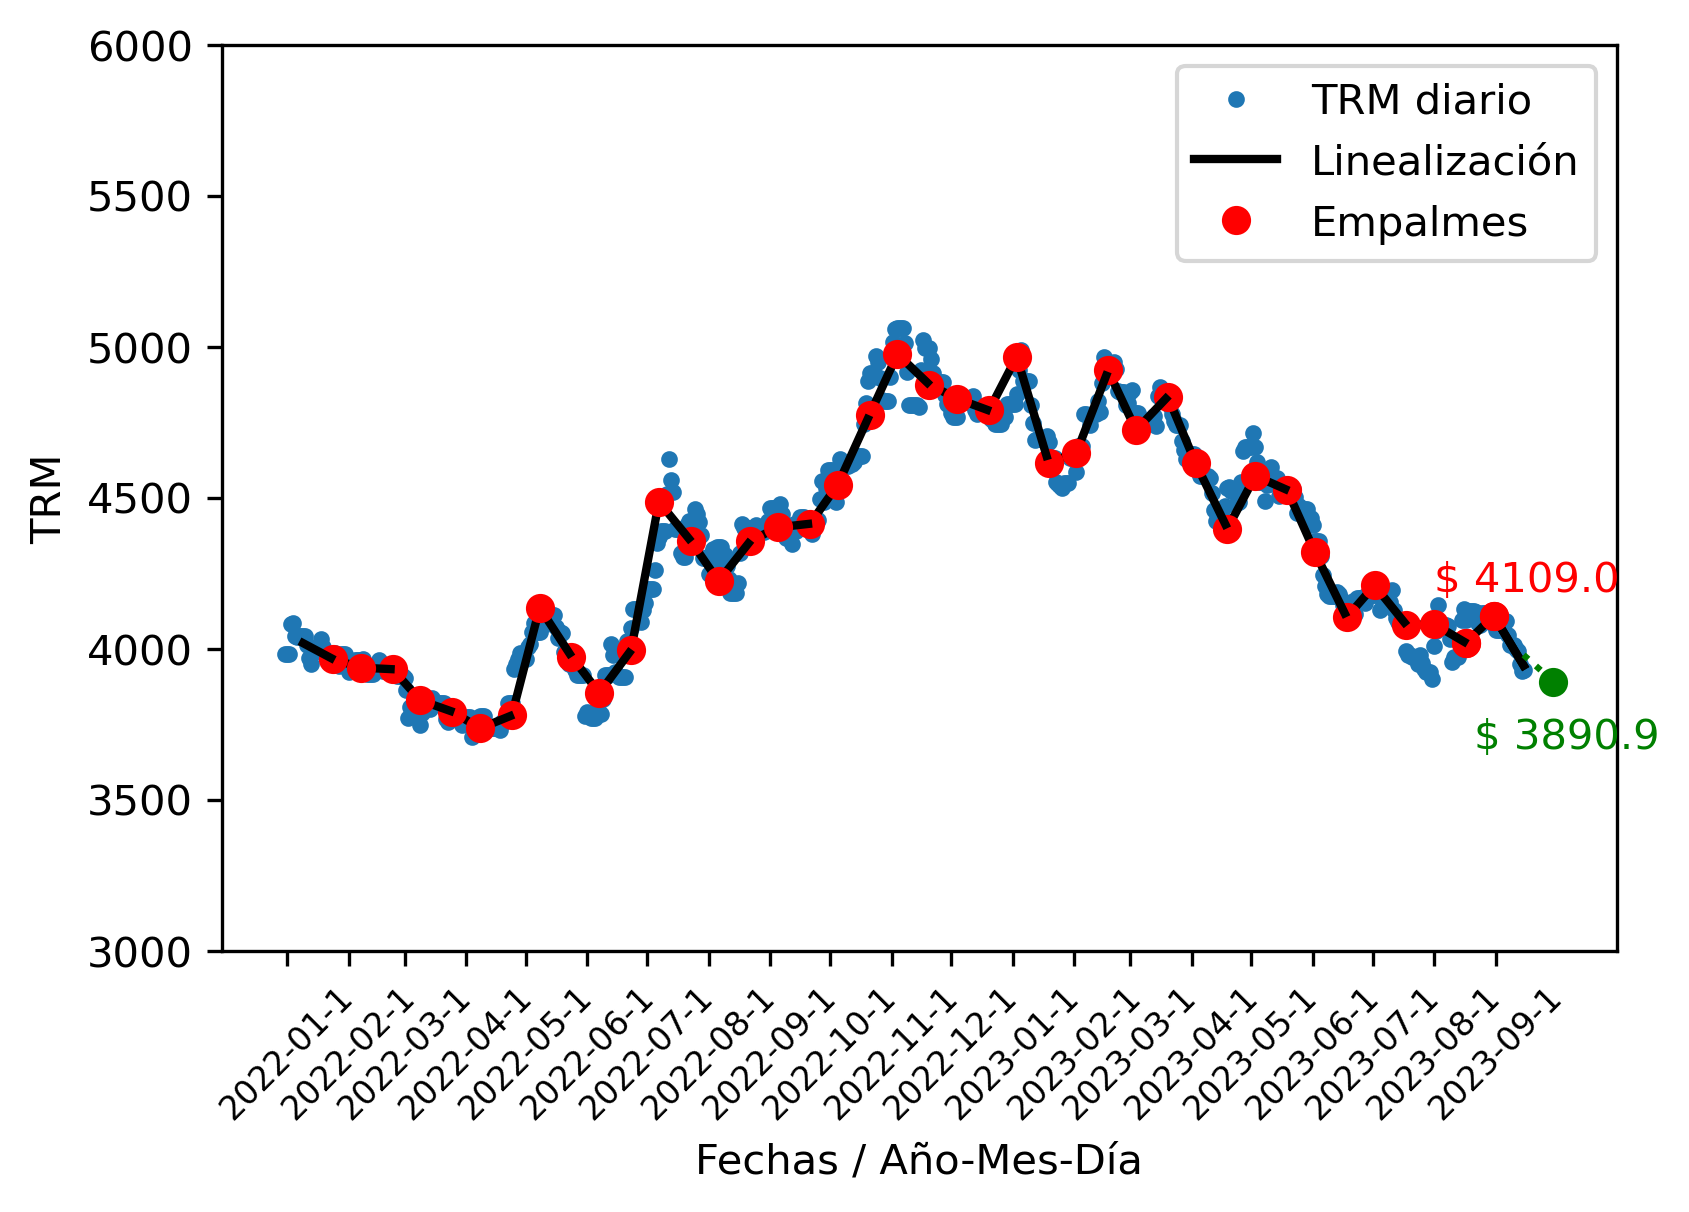

In [9]:
NumDays = 30
plt.figure(dpi=300)
plot_TMR_linealized(TRM_min=3000, TRM_max=6000)
delta_t, delta_x, slopes, intercepts = linealize(tau=NumDays)
# Pedicción a NumDays días si TMR sigue igual
t1 = delta_t[0][0]
t2 = delta_t[0][0] + 15
p = slopes[0], intercepts[0]

t_ext = [t1, t2]
x_ext = np.polyval(p, [t1, t2])
plt.plot(t_ext, x_ext, 'g:', label='Extrapolación con pendiente actual')
plt.plot(t_ext[-1], x_ext[-1], 'go')
plt.text(t_ext[-1]-40, x_ext[-1]-220, '$ %0.1f' % x_ext[-1], c='g')

## 4. Exportar modelo

In [10]:
slope_df = pd.DataFrame({    
    't0 [day]':[dt[1] for dt in delta_t],
    'TRM(t0) [COP/USD]':[dx[1] for dx in delta_x],
    't1 [day]':[dt[0] for dt in delta_t],
    'TRM(t1) [COP/USD]':[dx[0] for dx in delta_x],
    'slope [COP/USD per day]': list(slopes),
    'intercepts [COP/USD]': list(intercepts)
})
if not is_colab:
    slope_df.to_clipboard()
slope_df

,t0 [day],TRM(t0) [COP/USD],t1 [day],TRM(t1) [COP/USD],slope [COP/USD per day],intercepts [COP/USD]
0,594,4093.960000,623,3928.280000,-5.900432,7655.347956
1,564,4129.185103,593,4156.392023,0.938170,3600.057427
2,534,4145.720000,563,4069.390000,-1.564574,5011.604823
3,504,4561.142253,533,4177.686897,-13.222598,11225.331894
4,474,4532.430000,503,4521.640000,-0.580349,4853.638288
5,444,4749.705218,473,4579.133080,-5.881798,7361.223468
6,414,4918.940000,443,4824.250000,-4.563061,6775.704382
7,384,4763.963287,413,4891.160115,4.386098,3079.701846
8,354,4769.290000,383,4702.670000,-1.404670,5303.356426
9,324,4928.374345,353,4807.508046,-4.167803,6278.742649


End!